In [1]:
import glob
import os
from pathlib import Path
import pickle
import time

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.io as sio

from nils.reconstruction_module import cleanup_formfactor
from nils.simulate_spectrometer_signal import get_crisp_signal
import spectralvd

In [2]:
def current2formfactor(s, current, grating="both"):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set=grating)
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor


def center_currents(currents, n_samples=100):
    edges = np.array([spectralvd.find_edges(s, current) for s, current in currents])
    resampled = [spectralvd.resample(s, current, left, right, n_samples) for (s, current), (left, right) in zip(currents, edges)]
    centered = [spectralvd.center_on_zero(s, current, left, right) for (s, current), (left, right) in zip(resampled, edges)]
    return centered


data_files = ["rf_train", "formfactors_train", "currents_train", "rf_test", "formfactors_test", "currents_test"]
if all(os.path.isfile(f"data/{f}.pkl") for f in data_files):
    rf_train, formfactors_train, currents_train, rf_test, formfactors_test, currents_test = [spectralvd.from_pickle(f"data/{f}") for f in data_files]
else:
    with open("ocelot80k.pkl", "rb") as file:
        data = pickle.load(file)
       
    currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]
       
    rfparam_keys = ["chirp", "curv", "skew", "l1", "l2", "A1.v", "A1.phi", "AH1.v", "AH1.phi", "L1.v",
                    "L1.phi", "L2.v", "L2.phi"]
    rfparams = [[sample[k] for k in rfparam_keys] for sample in data]
       
    del data
    
    filtered_currents = [(s, current) for s, current in currents if current.max() > 1000]
    filtered_rfparams = [sample for sample, (_, current) in zip(rfparams, currents) if current.max() > 1000]

    formfactors = np.array([current2formfactor(*current, grating="both") for current in filtered_currents])
    
    X = list(zip(filtered_rfparams, formfactors))
    y = filtered_currents
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
       
    rf_train = [rf for rf, _ in X_train]
    formfactors_train = [ff for _, ff in X_train]
    currents_train = y_train
    rf_test = [rf for rf, _ in X_test]
    formfactors_test = [ff for _, ff in X_test]
    currents_test = center_currents(y_test)
    
    Path("data").mkdir(parents=True, exist_ok=True)
    datas = [rf_train, formfactors_train, currents_train, rf_test, formfactors_test, currents_test]
    for f, d in zip(data_files, datas):
       spectralvd.to_pickle(d, f"data/{f}")

In [3]:
max_rfs = np.abs(np.concatenate([rf_train,rf_test])).max(axis=0)

rf_train_errors = np.random.normal(scale=max_rfs*0.05, size=np.array(rf_train).shape)
rf_train_disturbed = np.array(rf_train) + rf_train_errors

rf_test_errors = np.random.normal(scale=max_rfs*0.05, size=np.array(rf_test).shape)
rf_test_disturbed = np.array(rf_test) + rf_test_errors

### Train Models

In [4]:
model_dir = "models"

In [5]:
path = f"{model_dir}/reverserfknn"
if os.path.isdir(path):
    revknn = spectralvd.ReverseRFKNN.load(path)
else:
    revknn = spectralvd.ReverseRFKNN(n_rf=13, n_neighbors=5, weights="uniform")
    revknn.fit(formfactors_train, rf_train)
    revknn.save(path)

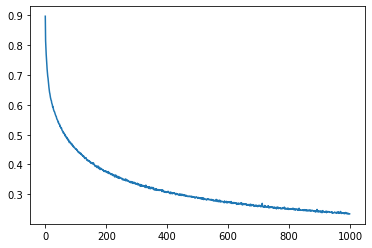

In [6]:
path = f"{model_dir}/reverserfann"
if os.path.isdir(path):
    revann = spectralvd.ReverseRFANN.load(path)
else:
    revann = spectralvd.ReverseRFANN(n_rf=13)
    revann.fit(formfactors_train, rf_train, epochs=1000, verbose=0)
    revann.save(path)

plt.plot(revann.history["loss"])
plt.show()

In [7]:
path = f"{model_dir}/reverserfdisturbedknn"
if os.path.isdir(path):
    revdknn = spectralvd.ReverseRFDisturbedKNN.load(path)
else:
    revdknn = spectralvd.ReverseRFDisturbedKNN(n_rf=13, n_neighbors=5, weights="uniform")
    revdknn.fit(rf_train_disturbed, formfactors_train, rf_train)
    revdknn.save(path)

INFO:tensorflow:Assets written to: models/reverserfdisturbedann/model/assets


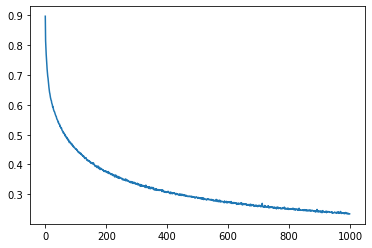

In [8]:
path = f"{model_dir}/reverserfdisturbedann"
if os.path.isdir(path):
    revdann = spectralvd.ReverseRFDisturbedANN.load(path)
else:
    revdann = spectralvd.ReverseRFDisturbedANN(n_rf=13)
    revdann.fit(rf_train_disturbed, formfactors_train, rf_train, epochs=1000, verbose=0)
    revdann.save(path)

plt.plot(revann.history["loss"])
plt.show()

### Evaluate

In [9]:
rfparam_keys = ["chirp", "curv", "skew", "l1", "l2", "A1.v", "A1.phi", "AH1.v", "AH1.phi", "L1.v",
                "L1.phi", "L2.v", "L2.phi"]

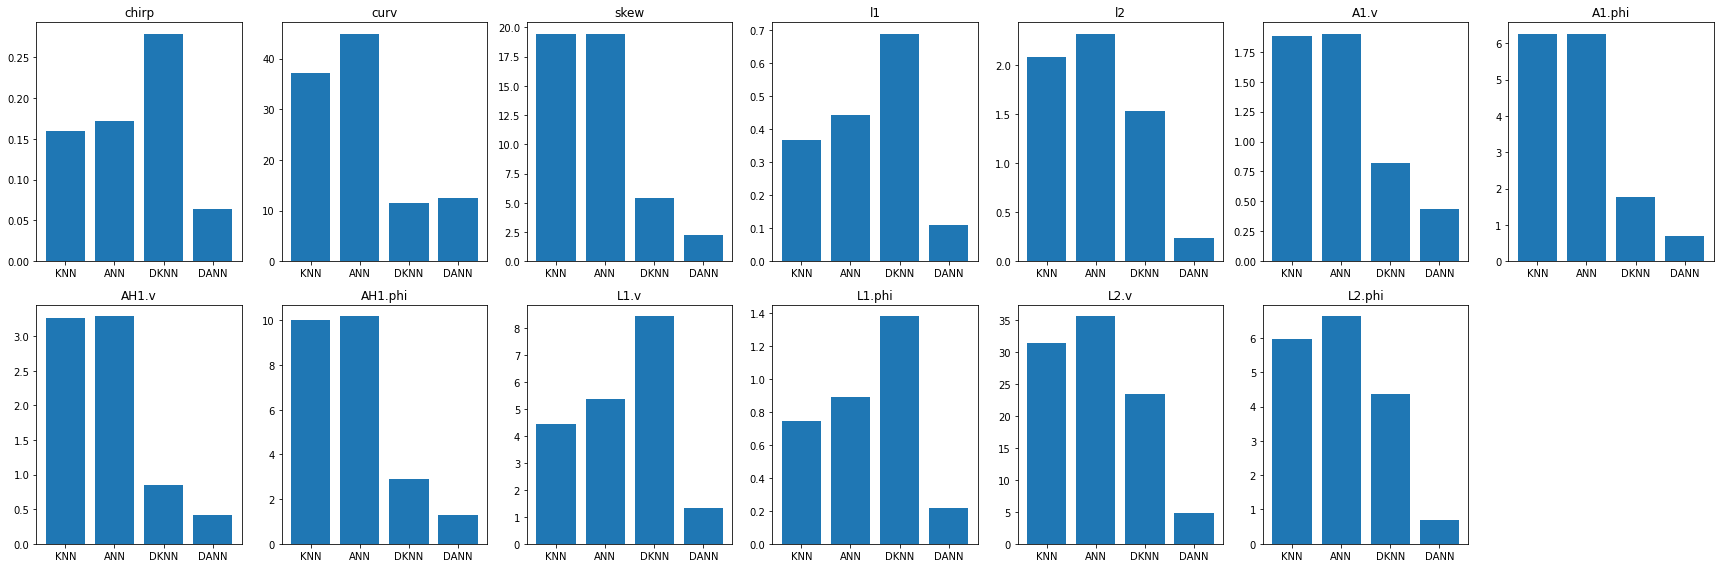

In [30]:
rf_test = np.array(rf_test)

knnpred = revknn.predict(formfactors_test)
knnerr = np.abs(rf_test - knnpred).mean(axis=0)

annpred = revann.predict(formfactors_test)
annerr = np.abs(rf_test - annpred).mean(axis=0)

knndpred = revdknn.predict(rf_test_disturbed, formfactors_test)
knnderr = np.abs(rf_test - knndpred).mean(axis=0)

anndpred = revdann.predict(rf_test_disturbed, formfactors_test)
annderr = np.abs(rf_test - anndpred).mean(axis=0)

vals = np.stack([knnerr, annerr, knnderr, annderr])

plt.figure(figsize=(24,8))
for i in range(13):
    plt.subplot(2, 7, i+1)
    plt.title(rfparam_keys[i])
    plt.bar(["KNN","ANN","DKNN","DANN"], vals[:,i])
plt.tight_layout()
plt.show()

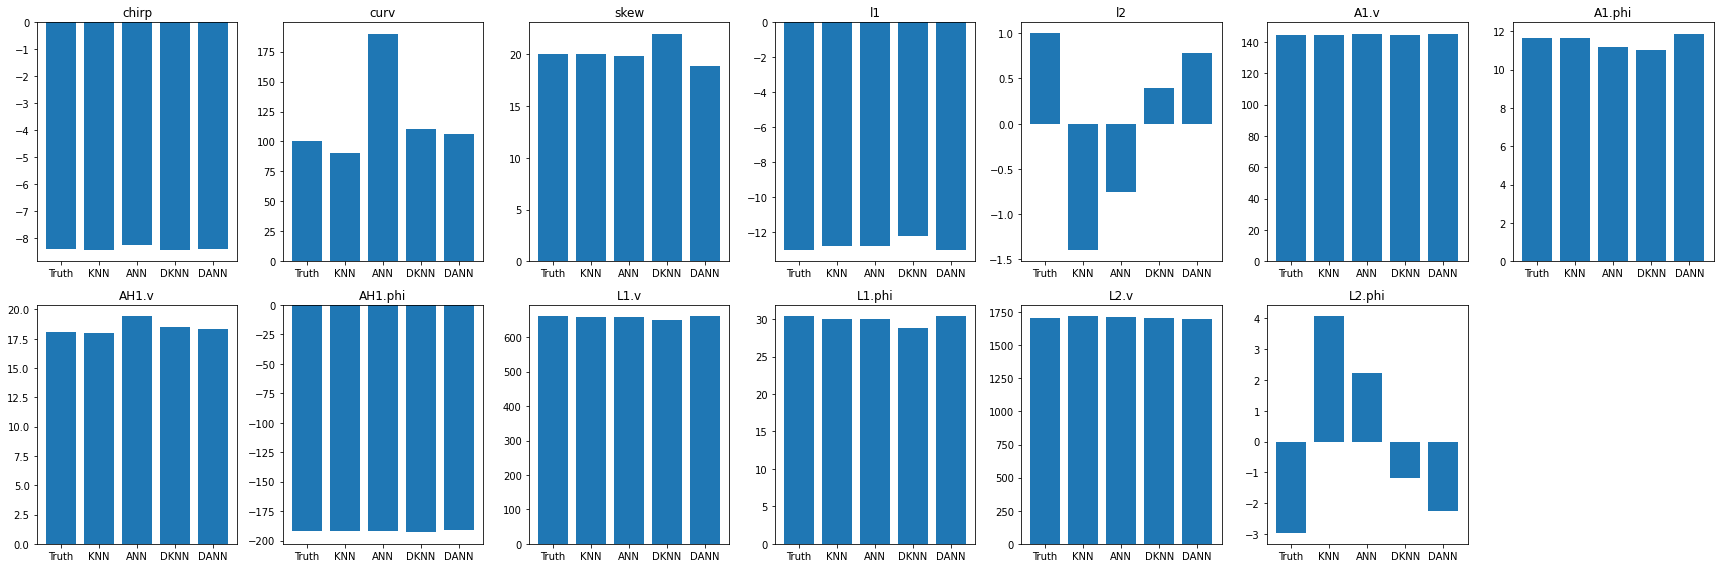

In [10]:
i = 0

knnpred = revknn.predict(formfactors_test[i:i+1]).squeeze()
annpred = revann.predict(formfactors_test[i:i+1]).squeeze()
knndpred = revdknn.predict(rf_test_disturbed[i:i+1], formfactors_test[i:i+1]).squeeze()
anndpred = revdann.predict(rf_test_disturbed[i:i+1], formfactors_test[i:i+1]).squeeze()

vals = np.stack([rf_test[i], knnpred, annpred, knndpred, anndpred])

plt.figure(figsize=(24,8))
for i in range(13):
    plt.subplot(2, 7, i+1)
    plt.title(rfparam_keys[i])
    plt.bar(["Truth","KNN","ANN","DKNN","DANN"], vals[:,i])
plt.tight_layout()
plt.show()

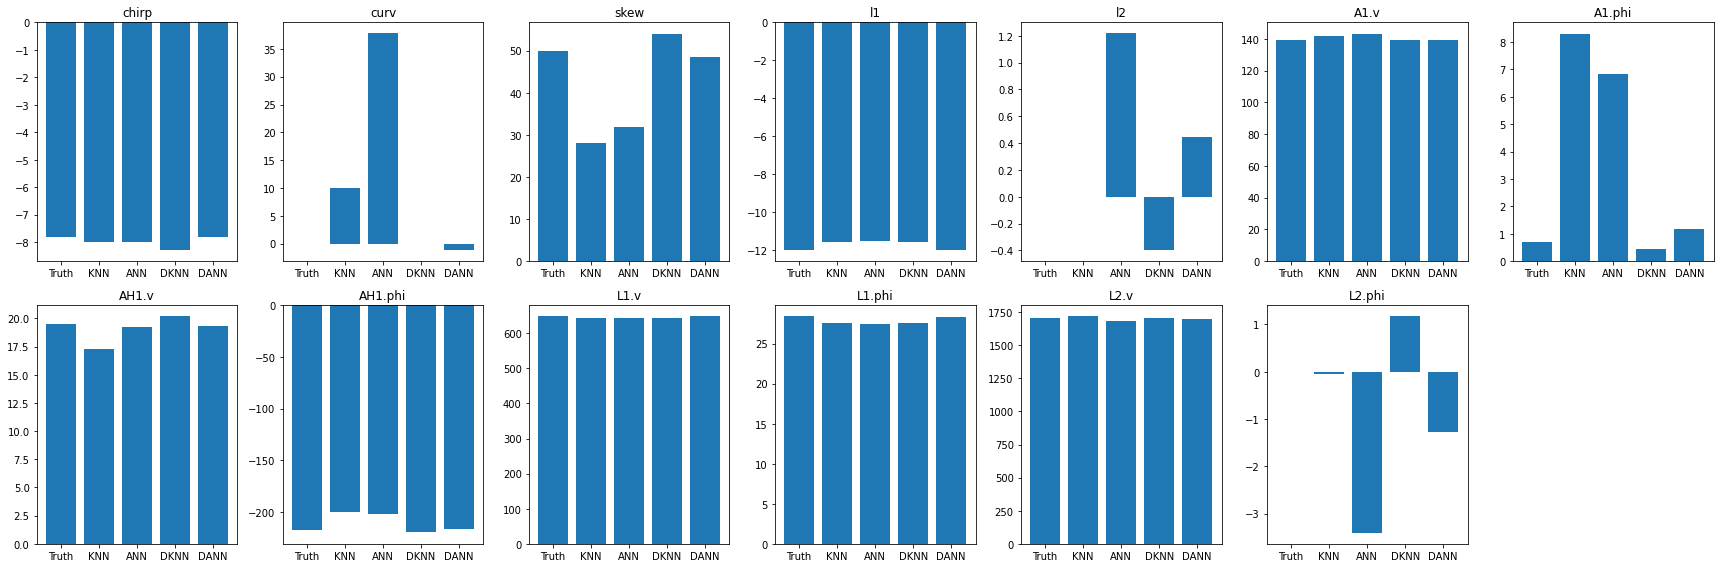

In [12]:
i = 42

knnpred = revknn.predict(formfactors_test[i:i+1]).squeeze()
annpred = revann.predict(formfactors_test[i:i+1]).squeeze()
knndpred = revdknn.predict(rf_test_disturbed[i:i+1], formfactors_test[i:i+1]).squeeze()
anndpred = revdann.predict(rf_test_disturbed[i:i+1], formfactors_test[i:i+1]).squeeze()

vals = np.stack([rf_test[i], knnpred, annpred, knndpred, anndpred])

plt.figure(figsize=(24,8))
for i in range(13):
    plt.subplot(2, 7, i+1)
    plt.title(rfparam_keys[i])
    plt.bar(["Truth","KNN","ANN","DKNN","DANN"], vals[:,i])
plt.tight_layout()
plt.show()